# Customer Segmentation with Clustering (Online Retail Dataset)

**Dataset:** Online Retail – UCI Machine Learning Repository  

**Description:** Transaction-level data for a UK-based online retailer, including invoice, product, quantity, price, customer ID and country.

**Objective:** Aggregate transactional data to the **customer level** and perform clustering to discover meaningful customer segments based on purchasing behaviour

I have:

- Cleaned and preprocessed the transactional data  
- Engineered customer-level behavioural features  
- Included **Country** as a geographical feature (one-hot encoded)  
- Applied **PCA** for dimensionality reduction  
- Trained and evaluated **K-Means** and **DBSCAN** clustering models  
- Interpreted the clusters and proposed business recommendations  
- Reflected on ethical and social implications of customer segmentation  



In [58]:
# Core libraries
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import VarianceThreshold

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# For reproducibility
RANDOM_STATE = 42

In [59]:
# Loading the Dataset (UCI Online Retail via ucimlrepo)
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

online_retail = fetch_ucirepo(id=352)  # Online Retail dataset
data = online_retail.data.original.copy()

print("Raw shape:", data.shape)
display(data.head())

print("\nMetadata:")
print(online_retail.metadata)

print("\nVariables:")
display(online_retail.variables)

Raw shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Metadata:
{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based custom

,name,role,type,demographic,description,units,missing_values
0,InvoiceNo,ID,Categorical,None,a 6-digit integral number uniquely assigned to...,None,no
1,StockCode,ID,Categorical,None,a 5-digit integral number uniquely assigned to...,None,no
2,Description,Feature,Categorical,None,product name,None,no
3,Quantity,Feature,Integer,None,the quantities of each product (item) per tran...,None,no
4,InvoiceDate,Feature,Date,None,the day and time when each transaction was gen...,None,no
5,UnitPrice,Feature,Continuous,None,product price per unit,sterling,no
6,CustomerID,Feature,Categorical,None,a 5-digit integral number uniquely assigned to...,None,no
7,Country,Feature,Categorical,None,the name of the country where each customer re...,None,no


In [60]:
print("Data info:")
print(data.info())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [61]:
print("\nMissing values per column:")
print(data.isna().sum())


Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [62]:
print("\nDescriptive statistics (numeric columns):")
display(data.describe().T)


Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


## Initial EDA - Base Dataset Analysis

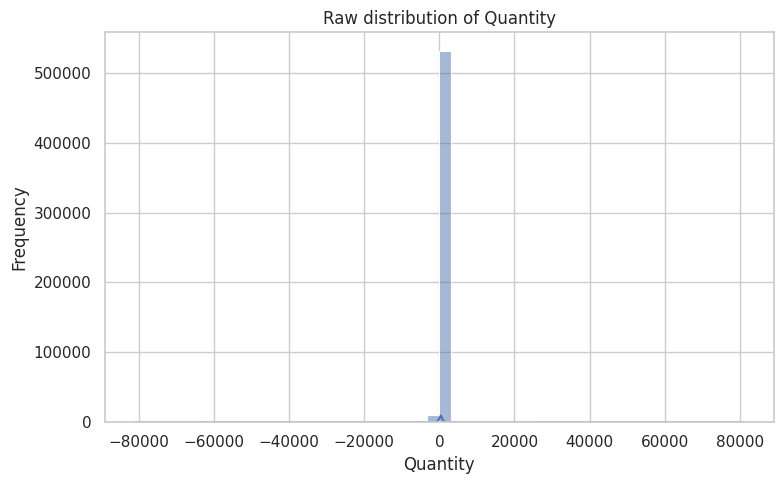

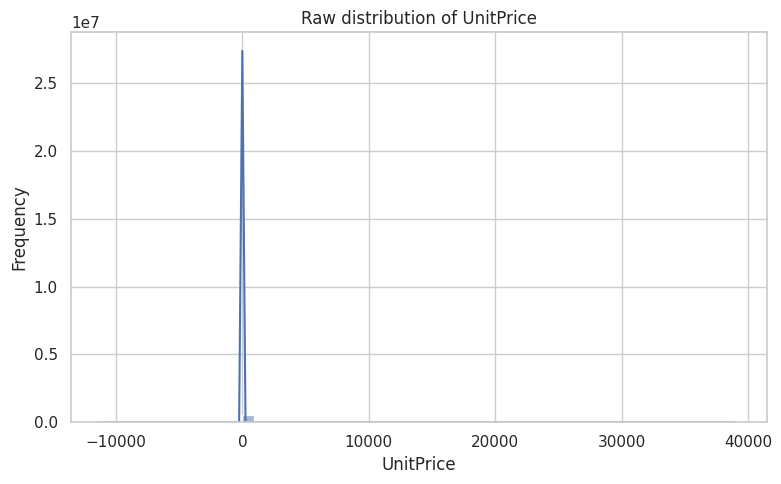

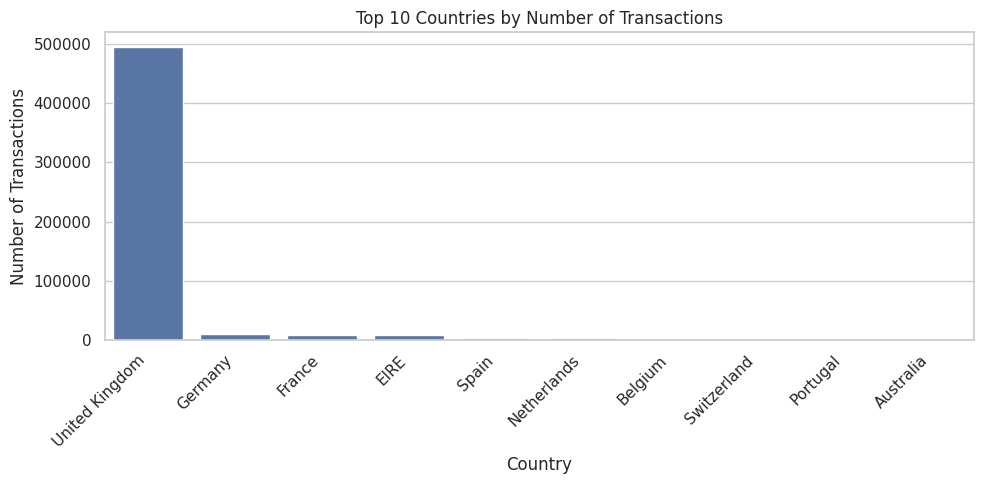

In [63]:
# Simple univariate EDA on key numeric variables
numeric_cols_raw = ["Quantity", "UnitPrice"]

for col in numeric_cols_raw:
    plt.figure()
    sns.histplot(data[col], bins=50, kde=True)
    plt.title(f"Raw distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Country-level distribution (top 10)
plt.figure(figsize=(10, 5))
top_countries = data["Country"].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Countries by Number of Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Country")
plt.tight_layout()
plt.show()

**Observations:**

*  Quantity and UnitPrice distributions are highly right-skewed with long tails, suggesting a handful of extreme purchases drive most variability.
*  Transactions are concentrated in the UK, with only modest volumes from other top countries, meaning this dataset is focused mainly on the UK shopper behaviour.

## 4. Data Cleaning (Transaction-Level)

Based on the EDA and dataset description, I will apply the following cleaning steps:

1. **Drop rows with missing CustomerID or Description`
   – These rows cannot be used for customer-level behaviour analysis.  
2. **Remove negative or zero Quantity**  
   – Negative quantities usually represent returns; we focus on positive purchase behaviour.  
3. **Remove zero or negative UnitPrice**  
   – Zero price may indicate errors or free items not relevant for revenue-based clustering.  
4. **Convert types** and compute TotalPrice per line item.  


In [64]:
# Drop rows with missing CustomerID or Description
data = data.dropna(subset=["CustomerID", "Description"])
print("After dropping missing CustomerID/Description:", data.shape)

After dropping missing CustomerID/Description: (406829, 8)


In [65]:
# Remove negative or zero quantity (likely returns / errors)
data = data[data["Quantity"] > 0]

In [66]:
# Remove zero or negative prices
data = data[data["UnitPrice"] > 0]

In [67]:
print("After removing invalid Quantity/UnitPrice:", data.shape)

After removing invalid Quantity/UnitPrice: (397884, 8)


In [68]:
# Convert types
data["CustomerID"] = data["CustomerID"].astype(int)
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [69]:
# TotalPrice per line item
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

display(data.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## 5. Customer-Level Feature Engineering

constructing behavioural features on customer-level to build a derived dataset:

- **Recency**: Days since last purchase  
- **Frequency**: Number of unique invoices  
- **Monetary**: Total spending  
- **AverageOrderValue**: Mean basket value  
- **UniqueItemsPurchased**  
- **AverageTimeBetweenOrders** (days)  
- **CustomerLifetimeDays** (days between first and last purchase)

In [70]:
analysis_date = data["InvoiceDate"].max()
print("Analysis date:", analysis_date)

Analysis date: 2011-12-09 12:50:00


In [71]:
# Recency
recency_df = (
    data.groupby("CustomerID")["InvoiceDate"]
    .max()
    .reset_index()
)
recency_df["Recency"] = (analysis_date - recency_df["InvoiceDate"]).dt.days
recency_df = recency_df[["CustomerID", "Recency"]]

In [72]:
# Frequency
frequency_df = (
    data.groupby("CustomerID")["InvoiceNo"]
    .nunique()
    .reset_index()
    .rename(columns={"InvoiceNo": "Frequency"})
)

In [73]:
# Monetary
monetary_df = (
    data.groupby("CustomerID")["TotalPrice"]
    .sum()
    .reset_index()
    .rename(columns={"TotalPrice": "Monetary"})
)

In [74]:
# Average Order Value
avg_order_value_df = (
    data.groupby("CustomerID")["TotalPrice"]
    .mean()
    .reset_index()
    .rename(columns={"TotalPrice": "AverageOrderValue"})
)

In [75]:
# Unique items purchased
unique_items_df = (
    data.groupby("CustomerID")["StockCode"]
    .nunique()
    .reset_index()
    .rename(columns={"StockCode": "UniqueItemsPurchased"})
)

In [76]:
# Average Time Between Orders (days)
data_sorted = data.sort_values(["CustomerID", "InvoiceDate"])
data_sorted["TimeBetweenOrders"] = data_sorted.groupby("CustomerID")["InvoiceDate"].diff()

avg_time_between_orders_df = (
    data_sorted.groupby("CustomerID")["TimeBetweenOrders"]
    .mean()
    .reset_index()
)
avg_time_between_orders_df["AverageTimeBetweenOrders"] = (
    avg_time_between_orders_df["TimeBetweenOrders"].dt.days
)
avg_time_between_orders_df = avg_time_between_orders_df[["CustomerID", "AverageTimeBetweenOrders"]]


In [77]:
# Customer Lifetime (days)
customer_lifetime_df = (
    data.groupby("CustomerID")["InvoiceDate"]
    .agg(["min", "max"])
    .reset_index()
)
customer_lifetime_df["CustomerLifetimeDays"] = (
    customer_lifetime_df["max"] - customer_lifetime_df["min"]
).dt.days
customer_lifetime_df = customer_lifetime_df[["CustomerID", "CustomerLifetimeDays"]]

In [78]:
# Combine all features
customer_features_df = recency_df.merge(frequency_df, on="CustomerID")
customer_features_df = customer_features_df.merge(monetary_df, on="CustomerID")
customer_features_df = customer_features_df.merge(avg_order_value_df, on="CustomerID")
customer_features_df = customer_features_df.merge(unique_items_df, on="CustomerID")
customer_features_df = customer_features_df.merge(avg_time_between_orders_df, on="CustomerID", how="left")
customer_features_df = customer_features_df.merge(customer_lifetime_df, on="CustomerID", how="left")

print("Customer-level shape:", customer_features_df.shape)
display(customer_features_df.head())

Customer-level shape: (4338, 8)


,CustomerID,Recency,Frequency,Monetary,AverageOrderValue,UniqueItemsPurchased,AverageTimeBetweenOrders,CustomerLifetimeDays
0,12346,325,1,77183.60,77183.600000,1,NaN,0
1,12347,1,7,4310.00,23.681319,103,2.0,365
2,12348,74,4,1797.24,57.975484,22,9.0,282
3,12349,18,1,1757.55,24.076027,73,0.0,0
4,12350,309,1,334.40,19.670588,17,0.0,0


In [79]:
print("\nMissing values in customer_features_df:")
print(customer_features_df.isna().sum())


Missing values in customer_features_df:
CustomerID                   0
Recency                      0
Frequency                    0
Monetary                     0
AverageOrderValue            0
UniqueItemsPurchased         0
AverageTimeBetweenOrders    71
CustomerLifetimeDays         0
dtype: int64


In [80]:
data_new = customer_features_df.dropna(subset=["AverageTimeBetweenOrders"])
print("After dropping NaN AverageTimeBetweenOrders:", data_new.shape)

print("\nRemaining missing values:")
print(data_new.isna().sum())

After dropping NaN AverageTimeBetweenOrders: (4267, 8)

Remaining missing values:
CustomerID                  0
Recency                     0
Frequency                   0
Monetary                    0
AverageOrderValue           0
UniqueItemsPurchased        0
AverageTimeBetweenOrders    0
CustomerLifetimeDays        0
dtype: int64


## Univariate EDA on derived data

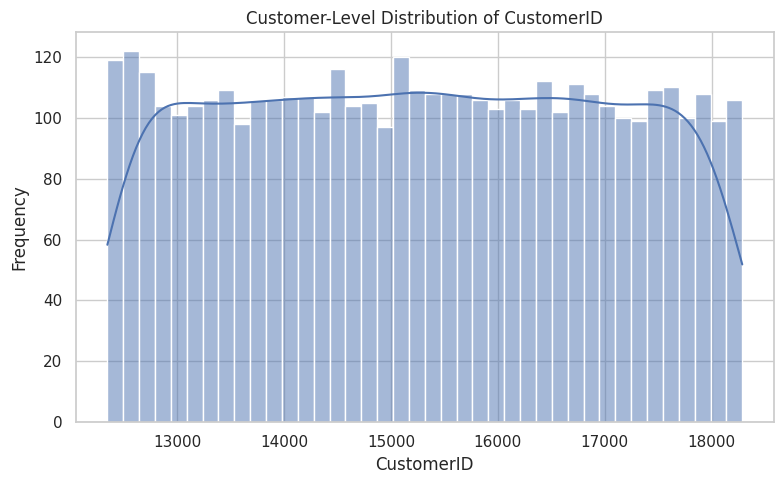

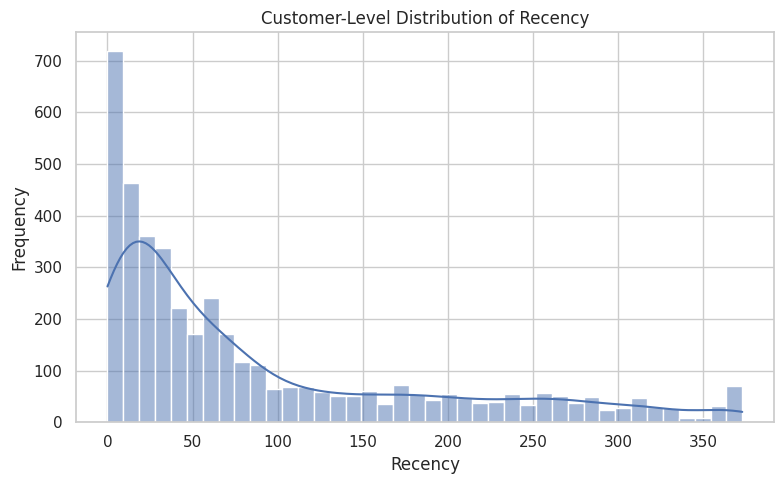

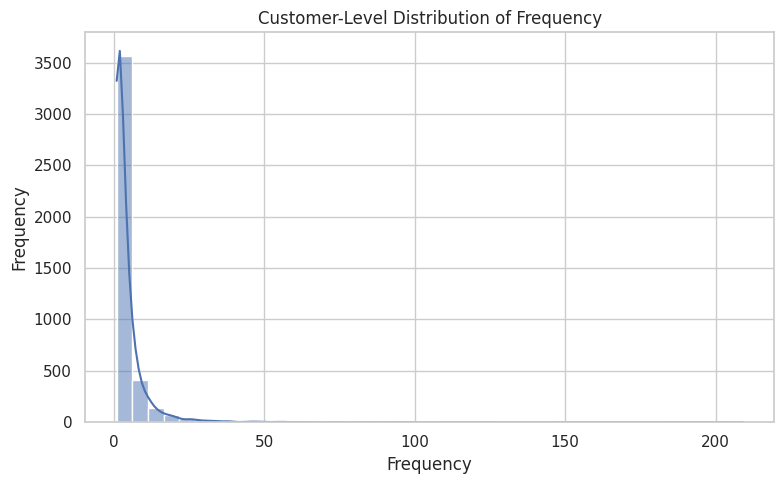

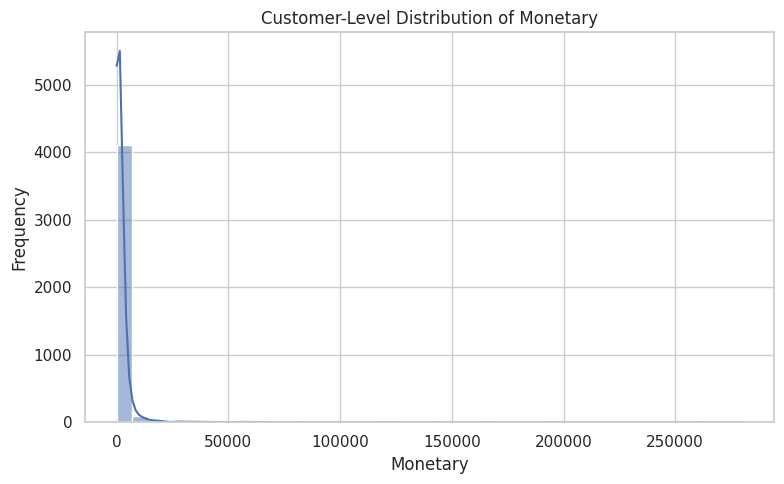

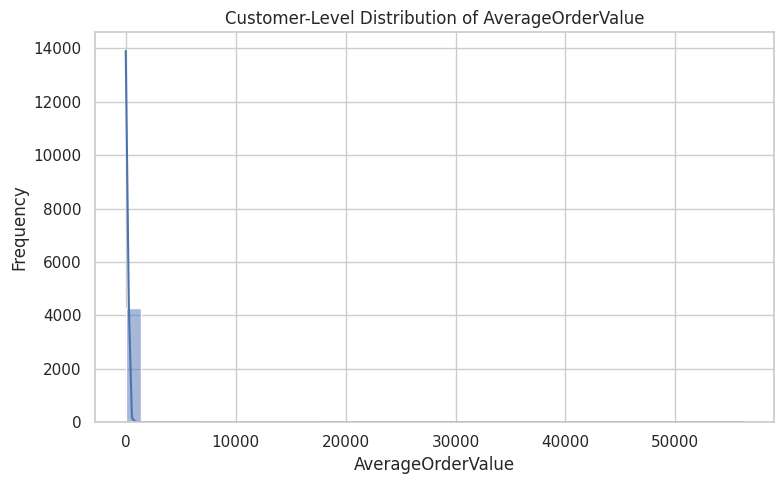

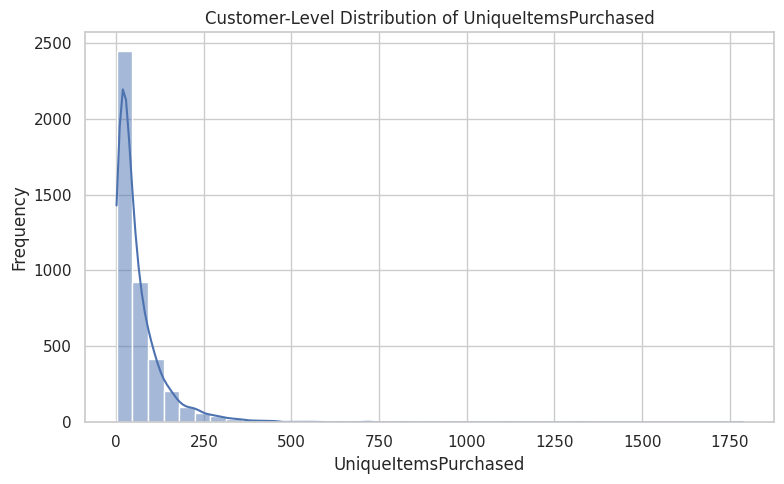

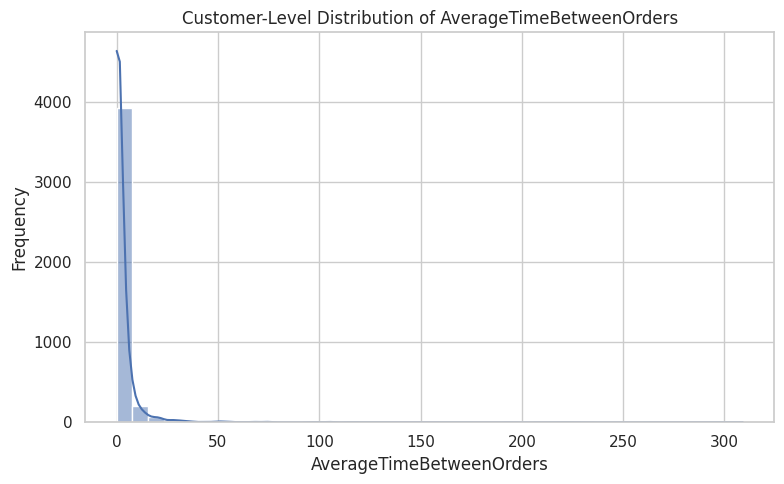

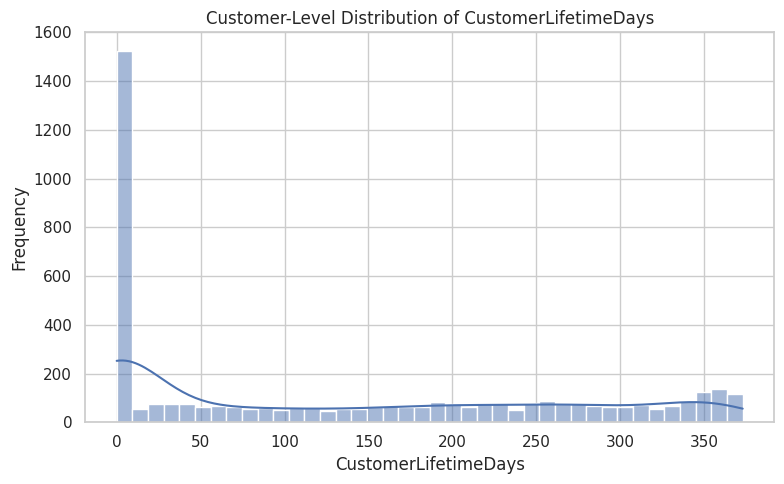

In [81]:
# Univariate distributions for customer-level numeric features
numeric_cols_customer = data_new.select_dtypes(include=np.number).columns

for col in numeric_cols_customer:
    plt.figure()
    sns.histplot(data_new[col], bins=40, kde=True)
    plt.title(f"Customer-Level Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

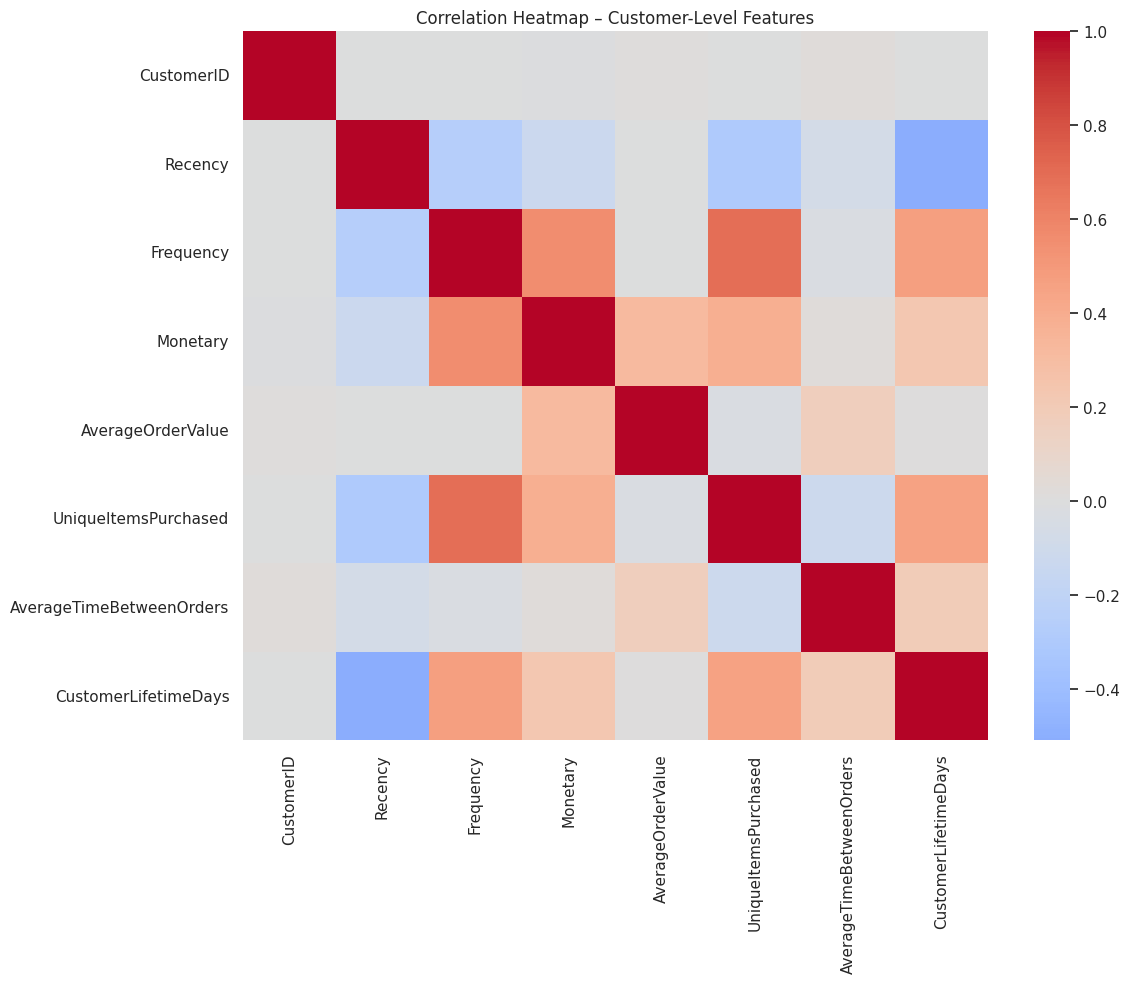

In [82]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = data_new[numeric_cols_customer].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap – Customer-Level Features")
plt.tight_layout()
plt.show()


**Observations:**

- Frequency, Monetary, AverageOrderValue, and UniqueItems show strong positive relationships, reflecting that high spenders also buy more often and in greater variety.
- Recency and AverageTimeBetweenOrders trend negatively against purchase intensity, highlighting that stale customers tend to buy less often.

## Data Preprocessing

In [83]:
customer_ids = data_new["CustomerID"].copy()

# Dropping unique columns
features_for_model = data_new.drop(columns=["CustomerID"])

print("Feature columns used for modelling (no Country):")
print(features_for_model.columns.tolist())

Feature columns used for modelling (no Country):
['Recency', 'Frequency', 'Monetary', 'AverageOrderValue', 'UniqueItemsPurchased', 'AverageTimeBetweenOrders', 'CustomerLifetimeDays']


In [84]:
x = features_for_model.copy()

print("Shape of features before scaling:", x.shape)
display(x.head())

Shape of features before scaling: (4267, 7)


,Recency,Frequency,Monetary,AverageOrderValue,UniqueItemsPurchased,AverageTimeBetweenOrders,CustomerLifetimeDays
1,1,7,4310.00,23.681319,103,2.0,365
2,74,4,1797.24,57.975484,22,9.0,282
3,18,1,1757.55,24.076027,73,0.0,0
4,309,1,334.40,19.670588,17,0.0,0
5,35,8,2506.04,29.482824,59,3.0,260


## Scaling

In [85]:
# Scaling
scaler = StandardScaler()
scaled_array = scaler.fit_transform(x)

df_scaled = pd.DataFrame(
    scaled_array,
    columns=x.columns,
    index=x.index
)

print("Scaled data shape:", df_scaled.shape)
display(df_scaled.head())

Scaled data shape: (4267, 7)


,Recency,Frequency,Monetary,AverageOrderValue,UniqueItemsPurchased,AverageTimeBetweenOrders,CustomerLifetimeDays
1,-0.899078,0.345008,0.249773,-0.025726,0.472467,-0.088515,1.760027
2,-0.159310,-0.042128,-0.029851,0.012885,-0.472650,0.556330,1.131394
3,-0.726803,-0.429264,-0.034268,-0.025282,0.122424,-0.272757,-1.004443
4,2.222135,-0.429264,-0.192639,-0.030242,-0.530991,-0.272757,-1.004443
5,-0.554529,0.474054,0.049025,-0.019194,-0.040930,0.003605,0.964768


In [86]:
# VarianceThreshold to remove low-variance features
X_for_variance = df_scaled.copy()

variance_selector = VarianceThreshold(threshold=0.05)
X_high_variance = variance_selector.fit_transform(X_for_variance)

features_to_keep = X_for_variance.columns[variance_selector.get_support()]

df_features_final = pd.DataFrame(
    X_high_variance,
    columns=features_to_keep,
    index=df_scaled.index
)

print(f"Original number of features: {X_for_variance.shape[1]}")
print(f"Number of features after VarianceThreshold: {df_features_final.shape[1]}")
print("Features kept:")
print(list(features_to_keep))

Original number of features: 7
Number of features after VarianceThreshold: 7
Features kept:
['Recency', 'Frequency', 'Monetary', 'AverageOrderValue', 'UniqueItemsPurchased', 'AverageTimeBetweenOrders', 'CustomerLifetimeDays']


## PCA – DIMENSIONALITY REDUCTION

In [87]:
# FUNCTION: Automatic PCA component selection

def pick_pca_k_by_variance(X_preprocessed, threshold=0.70, k_max=None, random_state=42, plot=False):
    """
    Automatically select the minimum number of PCA components needed
    to reach a specified explained variance threshold.

    Parameters
    ----------
    X_preprocessed : array-like or DataFrame
        Scaled numeric matrix after preprocessing.
    threshold : float
        Cumulative explained variance ratio you want (e.g., 0.70 or 0.90).
    k_max : int, optional
        Maximum components to consider. Defaults to min(n_features, 50).
    plot : bool
        Whether to display an explained-variance plot for inspection.

    Returns
    -------
    k : int
        The smallest number of components with cumulative EV >= threshold.
    cum_evr : np.array
        The cumulative explained variance array.
    """
    n_features = X_preprocessed.shape[1]
    if k_max is None:
        k_max = min(n_features, 50)

    pca_full = PCA(n_components=k_max, random_state=random_state)
    pca_full.fit(X_preprocessed)

    cum_evr = np.cumsum(pca_full.explained_variance_ratio_)

    k = int(np.searchsorted(cum_evr, threshold) + 1)
    k = min(k, k_max)

    if plot:
        plt.figure(figsize=(7, 4))
        plt.plot(range(1, len(cum_evr) + 1), cum_evr, marker="o")
        plt.axhline(y=threshold, color="r", linestyle="--", label=f"{threshold} threshold")
        plt.title("Cumulative Explained Variance")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative EV")
        plt.grid(True)
        plt.legend()
        plt.show()

    return k, cum_evr

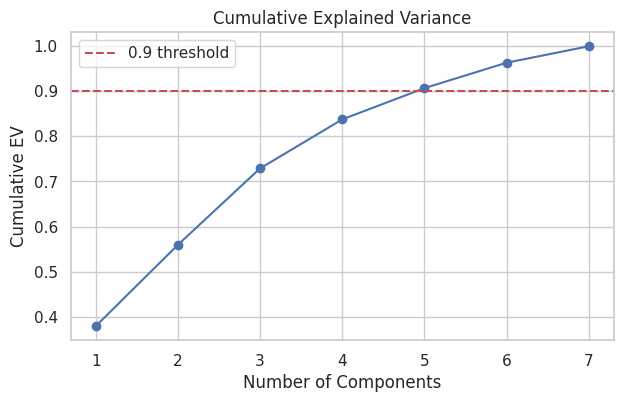

Selected PCA components to reach 90% variance: 5
Shape after PCA: (4267, 5)


In [88]:
# PCA automatic variance-based component selection

# Pick number of PCA components using the custom function
k, cum_evr = pick_pca_k_by_variance(
    df_features_final,
    threshold=0.90,
    plot=True
)

print(f"Selected PCA components to reach 90% variance: {k}")

# Now fit PCA with k components
pca = PCA(n_components=k, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(df_features_final)

print("Shape after PCA:", X_pca.shape)

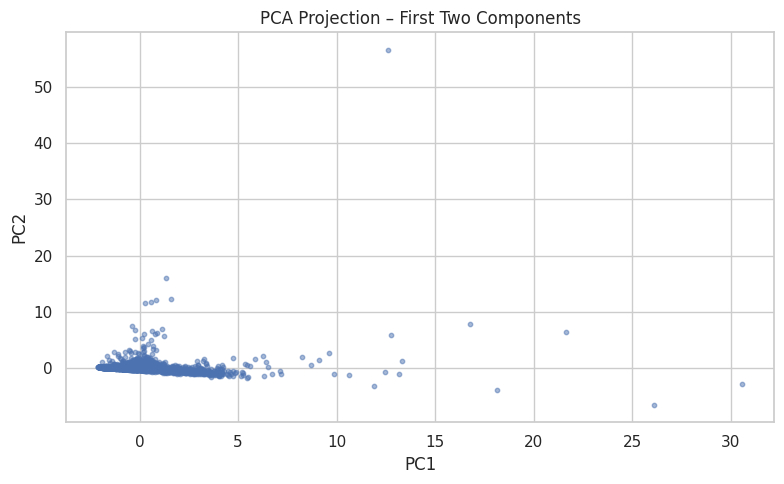

In [89]:
# First two PCs visualisation
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection – First Two Components")
plt.tight_layout()
plt.show()

**Observations:**

- The PCA projection shows customers spread along continuous gradients without clear separations, implying any clustering must find subtle density differences.
- The first two components capture the major variance directions while still leaving overlap, so higher-dimensional structure likely matters.

## K-Means Cluster

In [90]:
wcss = []
sil_scores = []
K_range = range(2, 11)

for k_clusters in K_range:
    kmeans_temp = KMeans(
        n_clusters=k_clusters,
        init="k-means++",
        random_state=RANDOM_STATE,
        n_init=10
    )
    labels_temp = kmeans_temp.fit_predict(X_pca)
    wcss.append(kmeans_temp.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels_temp))

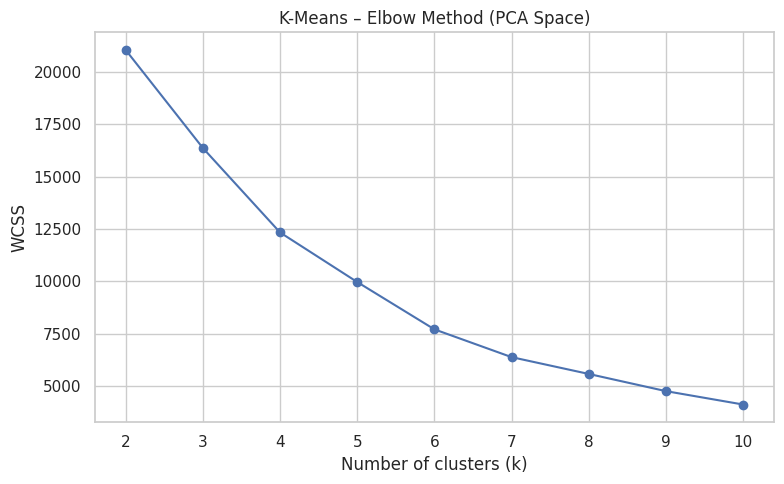

In [91]:
# Elbow plot
plt.figure()
plt.plot(list(K_range), wcss, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("K-Means – Elbow Method (PCA Space)")
plt.grid(True)
plt.tight_layout()
plt.show()

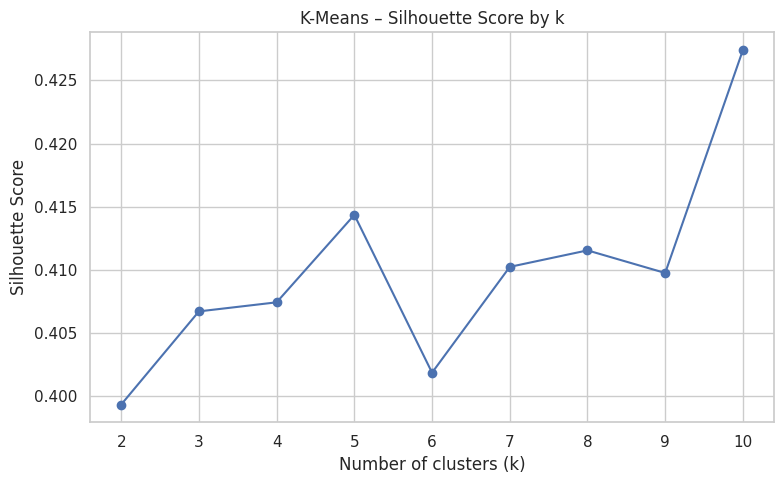

k = 2, Silhouette Score = 0.3994
k = 3, Silhouette Score = 0.4067
k = 4, Silhouette Score = 0.4074
k = 5, Silhouette Score = 0.4144
k = 6, Silhouette Score = 0.4019
k = 7, Silhouette Score = 0.4102
k = 8, Silhouette Score = 0.4115
k = 9, Silhouette Score = 0.4098
k = 10, Silhouette Score = 0.4274


In [92]:
# Silhouette plot
plt.figure()
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("K-Means – Silhouette Score by k")
plt.grid(True)
plt.tight_layout()
plt.show()

for kk, ss in zip(K_range, sil_scores):
    print(f"k = {kk}, Silhouette Score = {ss:.4f}")

**Observation**

- The optimal number of clusters from my Silhouette score is 10.
- I have chosen 5 as this is the next best score and is still close to to 10
- Also 10 clusters seams too large to use as it near defits the purpose of clustering shopper behaviour.

In [93]:
# Choose best_k AFTER you inspect the elbow & silhouette plots
best_k = 5

kmeans_final = KMeans(
    n_clusters=best_k,
    init="k-means++",
    random_state=RANDOM_STATE,
    n_init=10
)
kmeans_labels = kmeans_final.fit_predict(X_pca)

print("Final KMeans silhouette score:", silhouette_score(X_pca, kmeans_labels))
print("Final KMeans Davies-Bouldin score:", davies_bouldin_score(X_pca, kmeans_labels))

Final KMeans silhouette score: 0.4143559123918603
Final KMeans Davies-Bouldin score: 0.6733047711753615


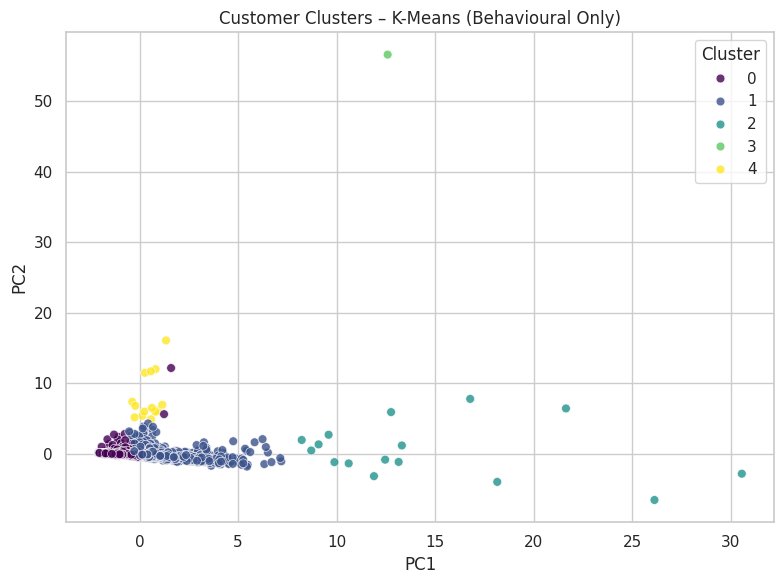

In [94]:
# Visualise K-Means clusters in PCA space
df_pca_viz = pd.DataFrame(
    data=X_pca[:, 0:2],
    columns=["PC1", "PC2"]
)
df_pca_viz["Cluster"] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_pca_viz,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="viridis",
    s=40,
    alpha=0.8
)
plt.title("Customer Clusters – K-Means (Behavioural Only)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

## DBSCAN

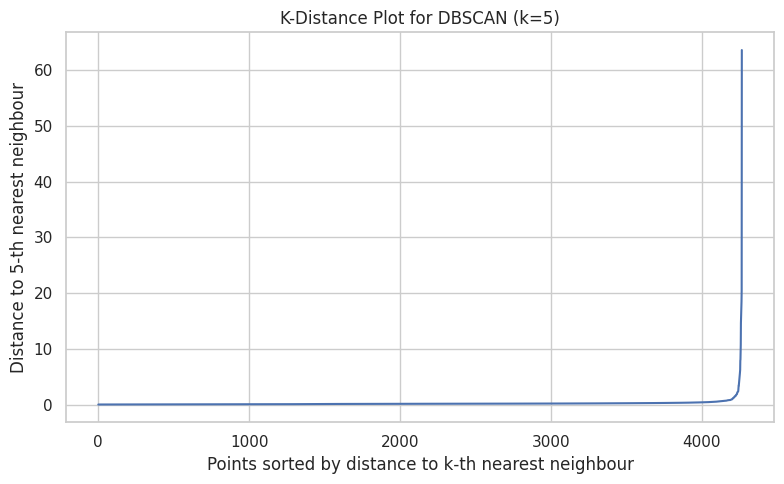

In [95]:
X_dbscan = X_pca

# K-distance plot
k_neighbors = 5
neigh = NearestNeighbors(n_neighbors=k_neighbors)
neigh.fit(X_dbscan)
distances, indices = neigh.kneighbors(X_dbscan)

distances = np.sort(distances[:, k_neighbors - 1], axis=0)

plt.figure()
plt.plot(distances)
plt.xlabel("Points sorted by distance to k-th nearest neighbour")
plt.ylabel(f"Distance to {k_neighbors}-th nearest neighbour")
plt.title(f"K-Distance Plot for DBSCAN (k={k_neighbors})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
# Grid search for (eps, min_samples)
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 20]

dbscan_results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_dbscan)
        unique_labels = set(labels)

        n_clusters = len([l for l in unique_labels if l != -1])
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            mask = labels != -1
            if mask.sum() > 1 and len(set(labels[mask])) > 1:
                sil = silhouette_score(X_dbscan[mask], labels[mask])
            else:
                sil = np.nan
        else:
            sil = np.nan

        dbscan_results.append({
            "eps": eps,
            "min_samples": ms,
            "silhouette": sil,
            "n_clusters": n_clusters,
            "n_noise": n_noise
        })

dbscan_results_df = pd.DataFrame(dbscan_results)
display(dbscan_results_df.sort_values(by="silhouette", ascending=False))

,eps,min_samples,silhouette,n_clusters,n_noise
6,1.5,5,0.801795,2,35
3,1.0,5,0.682491,2,51
0,0.5,5,0.236306,4,128
1,0.5,10,NaN,1,189
2,0.5,20,NaN,1,247
4,1.0,10,NaN,1,74
5,1.0,20,NaN,1,84
7,1.5,10,NaN,1,48
8,1.5,20,NaN,1,58
9,2.0,5,NaN,1,24


In [97]:
# Choose DBSCAN configuration based on results table & k-distance plot
chosen_eps = 1.5
chosen_min_samples = 5

dbscan_final = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples)
dbscan_labels = dbscan_final.fit_predict(X_dbscan)

unique_labels = set(dbscan_labels)
n_clusters = len([l for l in unique_labels if l != -1])
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN eps={chosen_eps}, min_samples={chosen_min_samples}")
print("Number of clusters (excluding noise):", n_clusters)
print("Number of noise points:", n_noise)

if n_clusters > 1:
    mask = dbscan_labels != -1
    if mask.sum() > 1 and len(set(dbscan_labels[mask])) > 1:
        sil_dbscan = silhouette_score(X_dbscan[mask], dbscan_labels[mask])
        print("DBSCAN silhouette score (excluding noise):", sil_dbscan)
    else:
        sil_dbscan = np.nan
else:
    sil_dbscan = np.nan

DBSCAN eps=1.5, min_samples=5
Number of clusters (excluding noise): 2
Number of noise points: 35
DBSCAN silhouette score (excluding noise): 0.8017945355543298


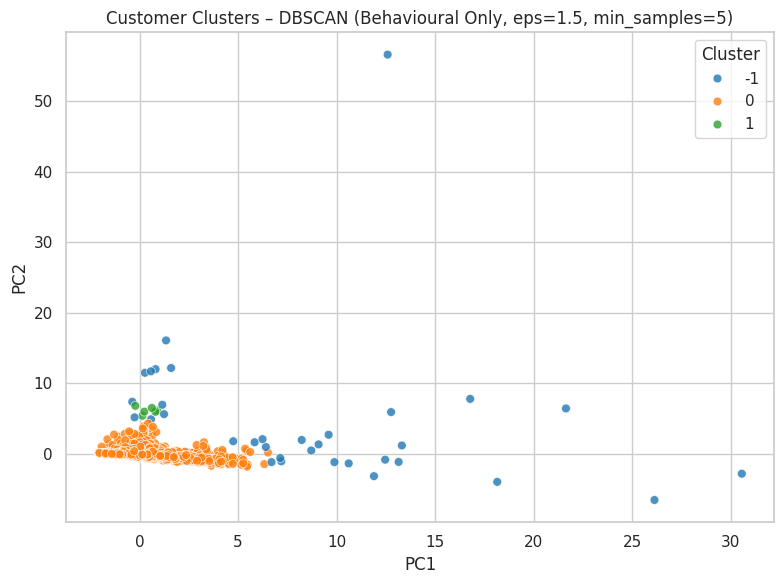

In [98]:
# Visualise DBSCAN clusters
df_dbscan_viz = pd.DataFrame(
    data=X_dbscan[:, 0:2],
    columns=["PC1", "PC2"]
)
df_dbscan_viz["Cluster"] = dbscan_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_dbscan_viz,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="tab10",
    s=40,
    alpha=0.8
)
plt.title(f"Customer Clusters – DBSCAN (Behavioural Only, eps={chosen_eps}, min_samples={chosen_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observations:**

- The DBSCAN scatter highlights irregular cluster shapes plus noise points (label -1) around the periphery, contrasting with the spherical K-Means partitions.
- Cluster sizes appear uneven, indicating density-based methods may isolate niche customer pockets.

In [99]:
# Choose DBSCAN config after inspecting dbscan_results_df & k-distance plot
chosen_eps = 1.0    # <- tweak based on results
chosen_min_samples = 10

dbscan_final = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples)
dbscan_labels = dbscan_final.fit_predict(X_dbscan)

unique_labels = set(dbscan_labels)
n_clusters = len([l for l in unique_labels if l != -1])
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN eps={chosen_eps}, min_samples={chosen_min_samples}")
print("Number of clusters (excluding noise):", n_clusters)
print("Number of noise points:", n_noise)

if n_clusters > 1:
    mask = dbscan_labels != -1
    if mask.sum() > 1 and len(set(dbscan_labels[mask])) > 1:
        sil_dbscan = silhouette_score(X_dbscan[mask], dbscan_labels[mask])
        print("DBSCAN silhouette score (excluding noise):", sil_dbscan)
    else:
        sil_dbscan = np.nan
else:
    sil_dbscan = np.nan

DBSCAN eps=1.0, min_samples=10
Number of clusters (excluding noise): 1
Number of noise points: 74


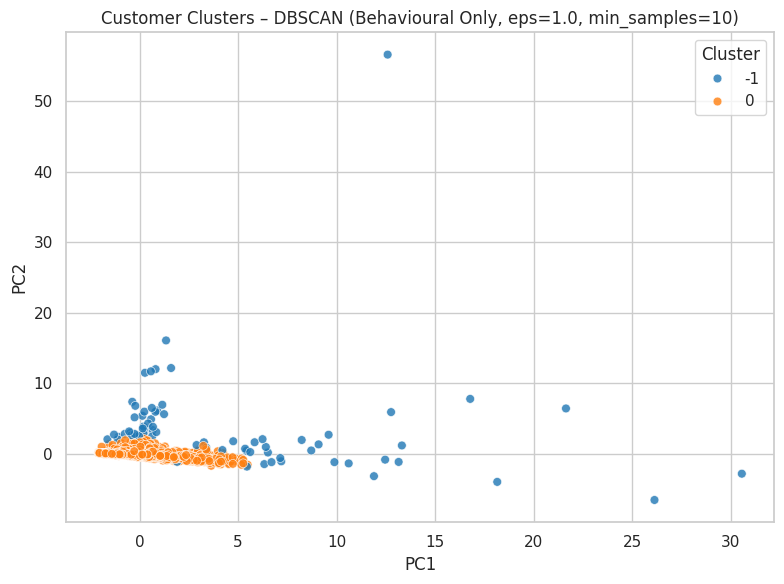

In [100]:
# Visualise DBSCAN clusters
df_dbscan_viz = pd.DataFrame(
    data=X_dbscan[:, 0:2],
    columns=["PC1", "PC2"]
)
df_dbscan_viz["Cluster"] = dbscan_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_dbscan_viz,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="tab10",
    s=40,
    alpha=0.8
)
plt.title(f"Customer Clusters – DBSCAN (Behavioural Only, eps={chosen_eps}, min_samples={chosen_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations:**

- The stricter DBSCAN view often shows many points tagged as noise and fewer dense clusters, making it clear when parameters are overly conservative.
- Remaining clusters, if any, occupy the densest zones of the PCA space, suggesting only the most consistent behaviours persist.

In [101]:
# Attach DBSCAN labels
customer_dbscan = data_new.copy()
customer_dbscan["DBSCANCluster"] = dbscan_labels

valid_dbscan = customer_dbscan[customer_dbscan["DBSCANCluster"] != -1]

cluster_profile_dbscan = (
    valid_dbscan.groupby("DBSCANCluster")[numeric_cols_customer]
    .mean()
    .round(2)
)
display(cluster_profile_dbscan)

,CustomerID,Recency,Frequency,Monetary,AverageOrderValue,UniqueItemsPurchased,AverageTimeBetweenOrders,CustomerLifetimeDays
DBSCANCluster,,,,,,,,
0,15287.89,90.21,3.91,1481.62,25.24,59.99,2.21,130.31


## MODEL COMPARISON – KMEANS VS DBSCAN

In [102]:
comparison_df = pd.DataFrame({
    "Model": ["KMeans", "DBSCAN (non-noise)"],
    "Silhouette": [
        silhouette_score(X_pca, kmeans_labels),
        sil_dbscan
    ],
    "DaviesBouldin": [
        davies_bouldin_score(X_pca, kmeans_labels),
        np.nan
    ],
    "NumClusters": [
        best_k,
        n_clusters
    ],
    "NumNoise(DBSCAN)": [
        0,
        n_noise
    ]
})

display(comparison_df)


,Model,Silhouette,DaviesBouldin,NumClusters,NumNoise(DBSCAN)
0,KMeans,0.414356,0.673305,5,0
1,DBSCAN (non-noise),NaN,NaN,1,74


**Observations:**

- K-Means yields complete internal metrics (silhouette, Davies–Bouldin), whereas DBSCAN may return NaN when it converges to a single cluster.
- Given the moderate K-Means scores and DBSCAN instability, K-Means serves as a dependable baseline

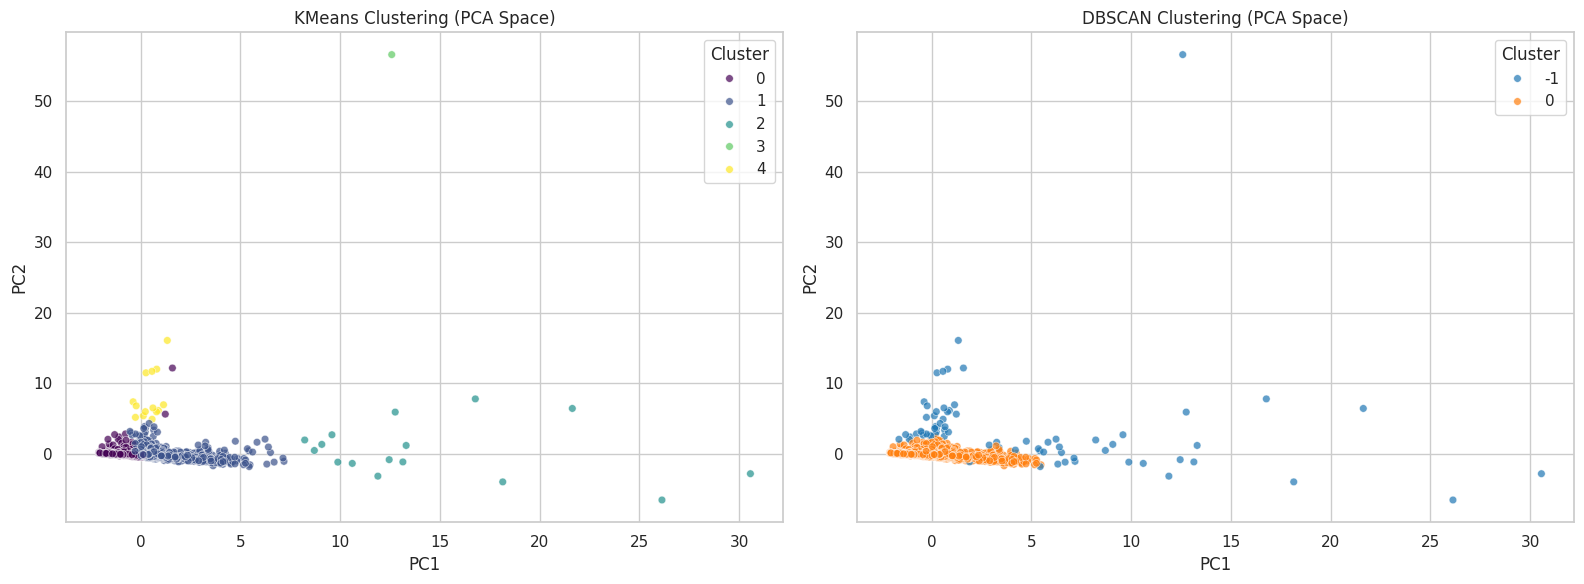

In [103]:
# Visual Comparision
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- KMeans Plot ---
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=kmeans_labels,
    palette="viridis",
    s=30,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("KMeans Clustering (PCA Space)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster", loc="best")

# --- DBSCAN Plot ---
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=dbscan_labels,
    palette="tab10",
    s=30,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("DBSCAN Clustering (PCA Space)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend(title="Cluster", loc="best")

plt.tight_layout()
plt.show()


/tmp/ipython-input-1912415656.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-1912415656.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


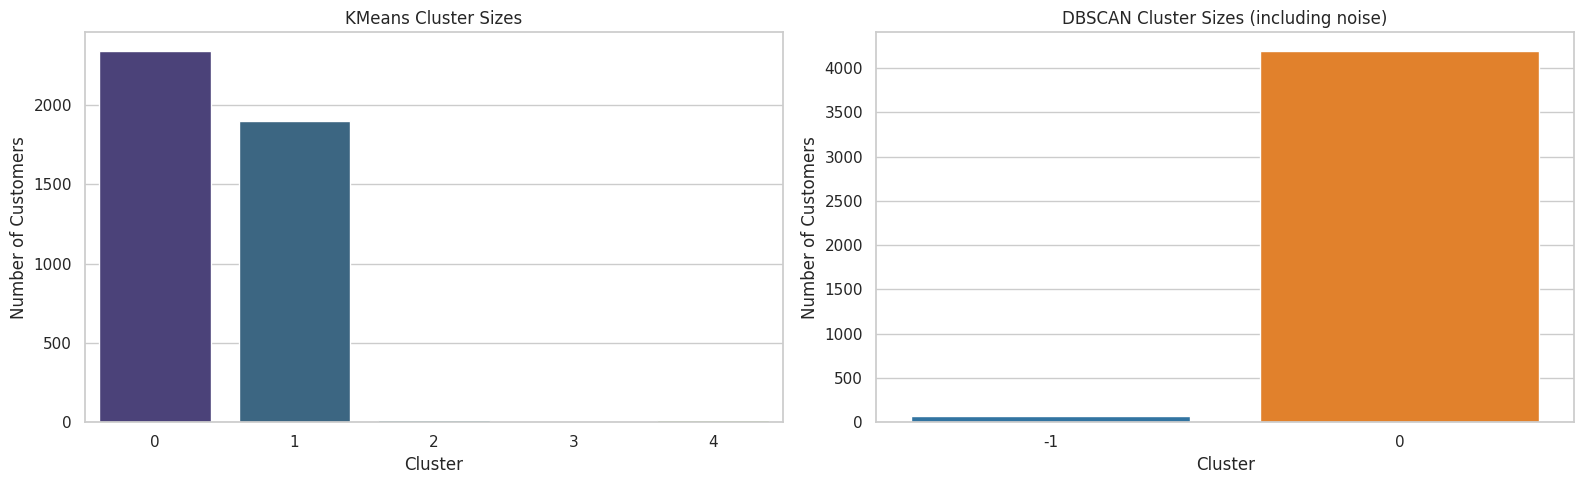

In [104]:
# Cluster Size Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# KMeans cluster count
sns.countplot(
    x=kmeans_labels,
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title("KMeans Cluster Sizes")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Number of Customers")

# DBSCAN cluster count
sns.countplot(
    x=dbscan_labels,
    palette="tab10",
    ax=axes[1]
)
axes[1].set_title("DBSCAN Cluster Sizes (including noise)")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Number of Customers")

plt.tight_layout()
plt.show()


## Customer Behaviour Distribution by Cluster

### K-Means

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


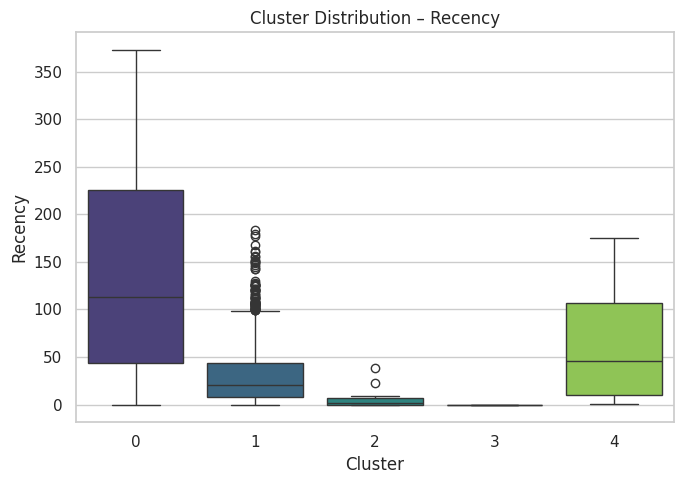

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


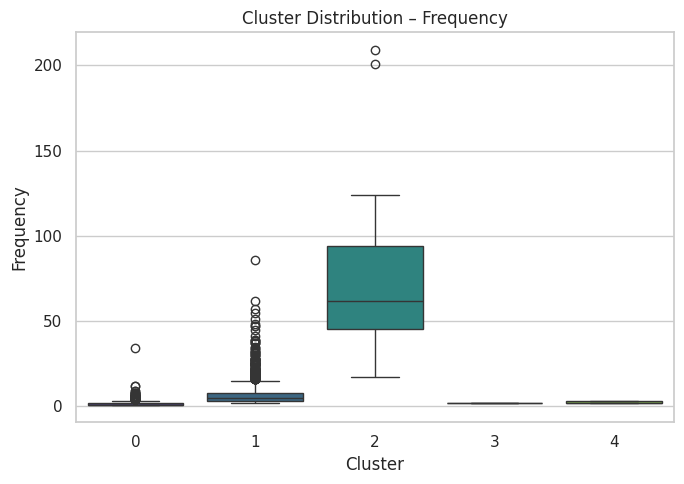

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


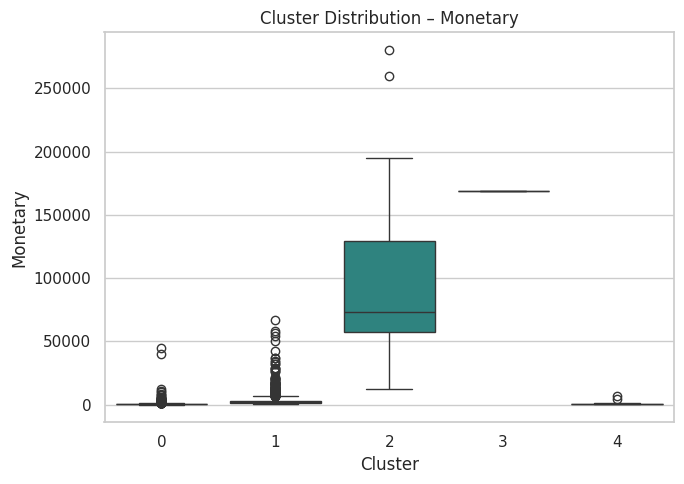

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


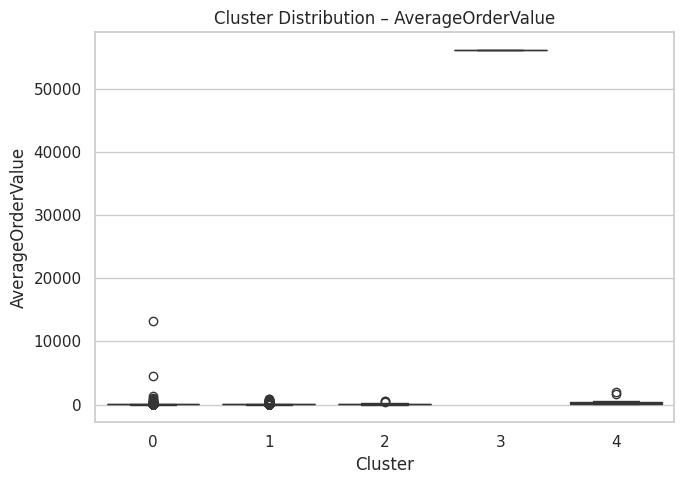

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


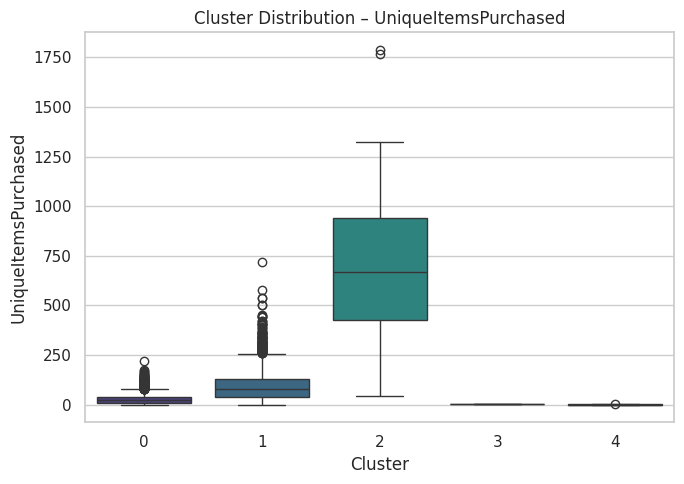

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


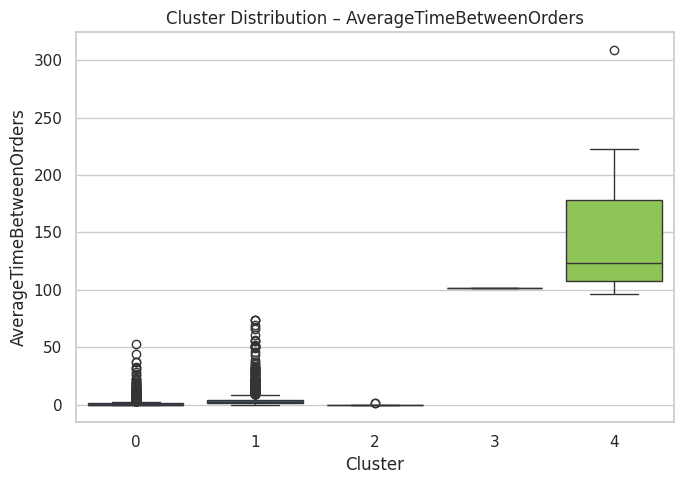

/tmp/ipython-input-2561013375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


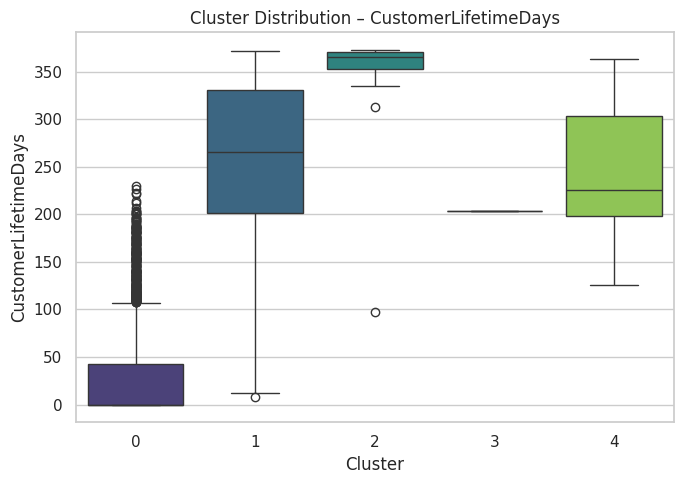

In [105]:
# Merge cluster labels back to your customer-level dataframe
customer_k = data_new.copy()
customer_k["Cluster"] = kmeans_labels

# Numeric features to visualise
features_to_plot = [
    "Recency",
    "Frequency",
    "Monetary",
    "AverageOrderValue",
    "UniqueItemsPurchased",
    "AverageTimeBetweenOrders",
    "CustomerLifetimeDays"
]

for feature in features_to_plot:
    if feature in customer_k.columns:
        plt.figure(figsize=(7, 5))
        sns.boxplot(
            data=customer_k,
            x="Cluster",
            y=feature,
            palette="viridis"
        )
        plt.title(f"Cluster Distribution – {feature}")
        plt.xlabel("Cluster")
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show()


### DBSCAN

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


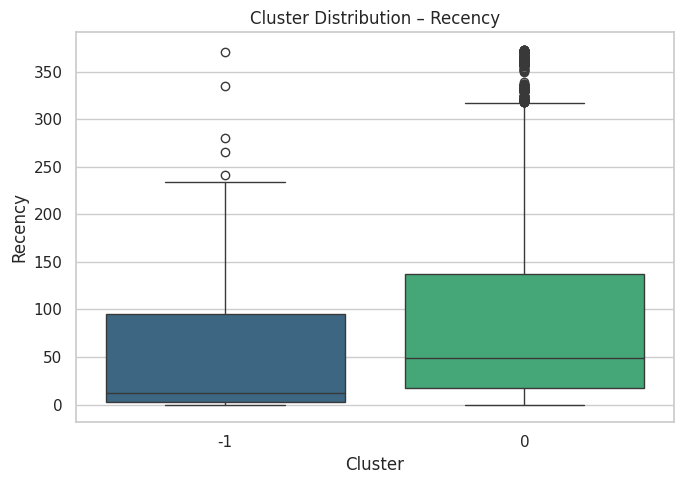

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


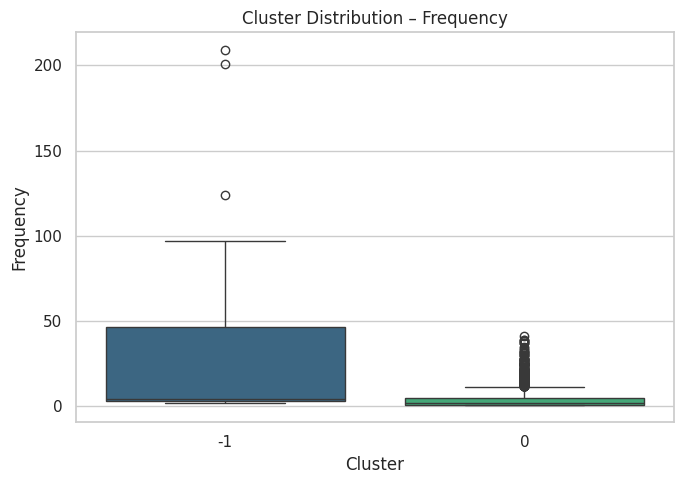

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


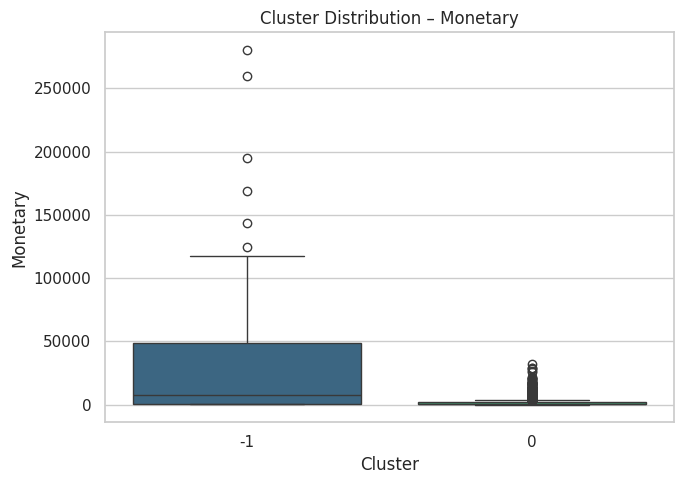

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


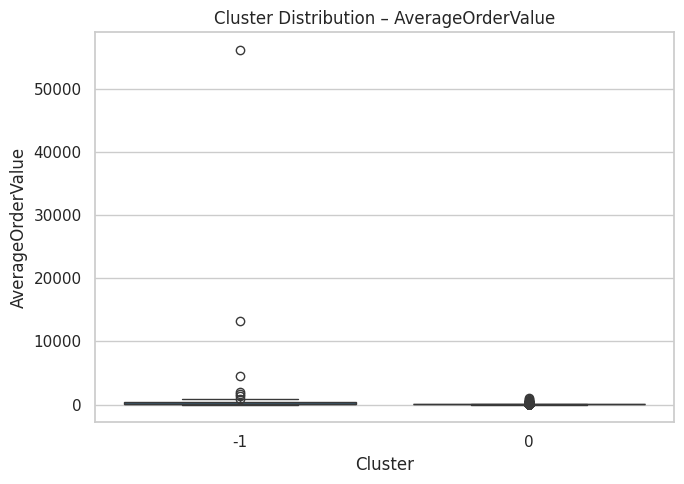

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


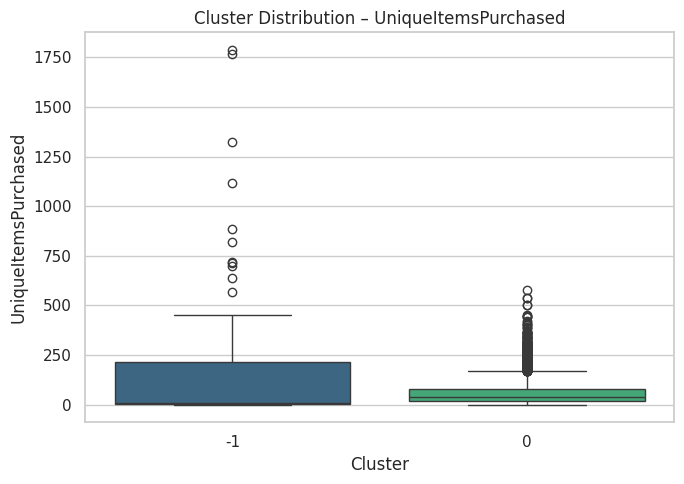

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


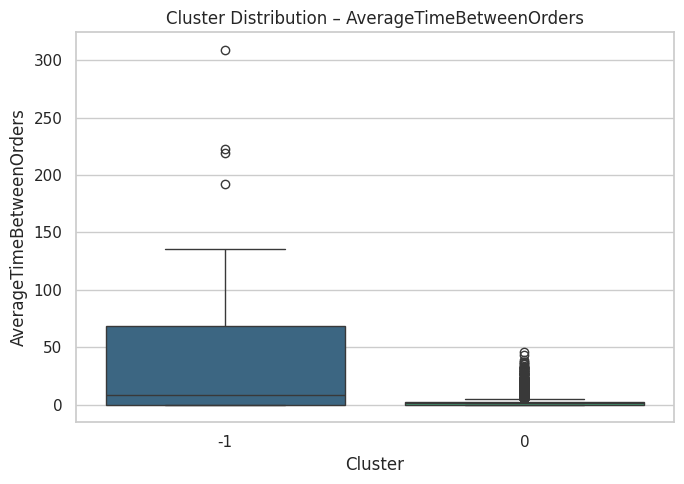

/tmp/ipython-input-180005284.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


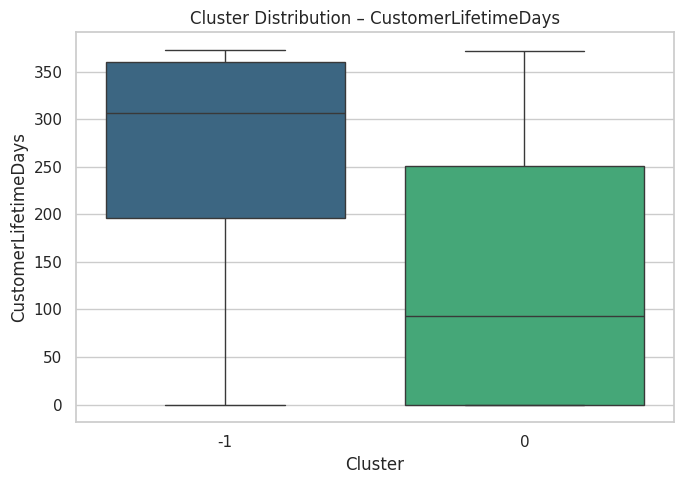

In [106]:
# Merge cluster labels back to your customer-level dataframe
customer_k = data_new.copy()
customer_k["Cluster"] = dbscan_labels

# Numeric features to visualise
features_to_plot = [
    "Recency",
    "Frequency",
    "Monetary",
    "AverageOrderValue",
    "UniqueItemsPurchased",
    "AverageTimeBetweenOrders",
    "CustomerLifetimeDays"
]

for feature in features_to_plot:
    if feature in customer_k.columns:
        plt.figure(figsize=(7, 5))
        sns.boxplot(
            data=customer_k,
            x="Cluster",
            y=feature,
            palette="viridis"
        )
        plt.title(f"Cluster Distribution – {feature}")
        plt.xlabel("Cluster")
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show()


### **Insights and Recommendations**
- **Skewed spending patterns:** Heavy-tailed quantity and revenue-related features mean a small share of customers drive most value; consider log or winsorized transforms when training additional models.
- **Segmentation baseline:** A five-cluster K-Means solution balances compactness and interpretability; profile these clusters (spend level, recency, product mix) to design differentiated campaigns.
- **Reactivation focus:** High recency and long inter-purchase gaps for many customers suggest retention programs (email/discounts) could re-engage dormant segments.
- **DBSCAN usage:** Use density-based clustering selectively for detecting niche cohorts; tune eps/min_samples with k-distance plots and validate stability before operationalizing.
- **Monitoring:** Refresh the clustering periodically as seasonality and new products shift behaviour, recalibrating scaling and PCA if feature distributions drift.